In [7]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as mpatches
import seaborn as sns
import itertools
%matplotlib inline

import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
#init_notebook_mode(connected=True)

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
#from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import tree
#import lightgbm as lgb
#from lightgbm import LGBMClassifier
import xgboost as xgb

from sklearn.model_selection import train_test_split
from scipy import interp
from sklearn.metrics import classification_report, accuracy_score, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn import metrics
from sklearn.metrics import confusion_matrix


import time
import warnings
warnings.filterwarnings("ignore")

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
import time

seed=47

import os
#for dirname, _, filenames in os.walk('/Data'):
    #for filename in filenames:
       # print(os.path.join(dirname, filename))

# Importing Data

In [14]:
invoice_test = pd.read_csv('D:\Python\Machine_Learning\Fraud Detection\efficacy-of-SFS-for-credit-card-fraud-detection-master\Data\invoice_test.csv',low_memory=False)
invoice_train = pd.read_csv('D:\Python\Machine_Learning\Fraud Detection\efficacy-of-SFS-for-credit-card-fraud-detection-master\Data\invoice_train.csv',low_memory=False)
client_test = pd.read_csv('D:\Python\Machine_Learning\Fraud Detection\efficacy-of-SFS-for-credit-card-fraud-detection-master\Data\client_test.csv',low_memory=False)
client_train = pd.read_csv('D:\Python\Machine_Learning\Fraud Detection\efficacy-of-SFS-for-credit-card-fraud-detection-master\Data\client_train.csv',low_memory=False)
sample_submission = pd.read_csv('D:\Python\Machine_Learning\Fraud Detection\efficacy-of-SFS-for-credit-card-fraud-detection-master\Data\SampleSubmission (2).csv',low_memory=False)

# Basic Exploratory Data Analysis(EDA)

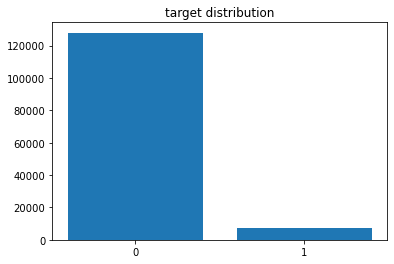

In [15]:
ds = client_train.groupby(['target'])['client_id'].count()
plt.bar(x=ds.index, height=ds.values, tick_label =[0,1])
plt.title('target distribution')
plt.show()

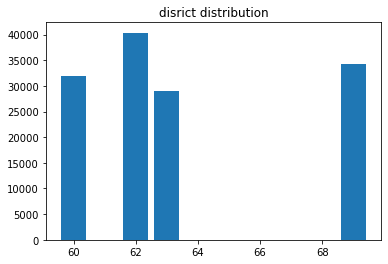

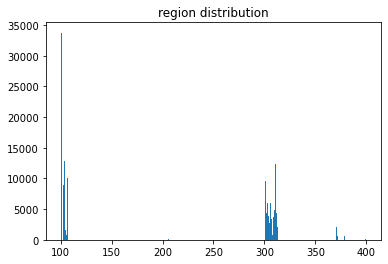

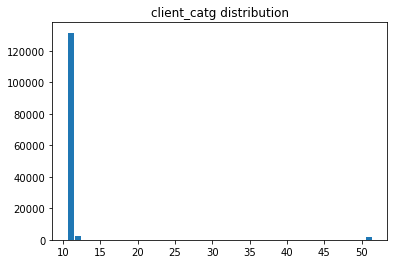

In [16]:
for col in ['disrict','region','client_catg']:
    ds = client_train.groupby([col])['client_id'].count()
    plt.bar(x=ds.index, height=ds.values)
    plt.title(col+' distribution')
    plt.show()

In [17]:
print('Number of missing rows in invoice_train:',invoice_train.isna().sum().sum())
print('Number of missing rows in invoice_test:',invoice_test.isna().sum().sum(),'\n')
print('Number of missing rows in client_train:',client_train.isna().sum().sum())
print('Number of missing rows in client_test:',client_test.isna().sum().sum())

Number of missing rows in invoice_train: 0
Number of missing rows in invoice_test: 0 

Number of missing rows in client_train: 0
Number of missing rows in client_test: 0


In [18]:
print('Number of unique values in invoice_train:')
for col in invoice_train.columns:
    print(f"{col} - {invoice_train[col].nunique()}")

Number of unique values in invoice_train:
client_id - 135493
invoice_date - 8275
tarif_type - 17
counter_number - 201893
counter_statue - 12
counter_code - 42
reading_remarque - 8
counter_coefficient - 16
consommation_level_1 - 8295
consommation_level_2 - 12576
consommation_level_3 - 2253
consommation_level_4 - 12075
old_index - 155648
new_index - 157980
months_number - 1370
counter_type - 2


# Feature Engineering

In [77]:
def feature_change(cl, inv):

    cl['client_catg'] = cl['client_catg'].astype('category')
    cl['disrict'] = cl['disrict'].astype('category')
    cl['region'] = cl['region'].astype('category')
    cl['region_group'] = cl['region'].apply(lambda x: 100 if x<100 else 300 if x>300 else 200)
    cl['creation_date'] = pd.to_datetime(cl['creation_date'])
    
    cl['coop_time'] = (2019 - cl['creation_date'].dt.year)*12 - cl['creation_date'].dt.month

    inv['counter_type'] = inv['counter_type'].map({"ELEC":1,"GAZ":0})
    inv['counter_statue'] = inv['counter_statue'].map({0:0,1:1,2:2,3:3,4:4,5:5,769:5,'0':0,'5':5,'1':1,'4':4,'A':0,618:5,269375:5,46:5,420:5})
    
    inv['invoice_date'] = pd.to_datetime(inv['invoice_date'], dayfirst=True)
    inv['invoice_month'] = inv['invoice_date'].dt.month
    inv['invoice_year'] = inv['invoice_date'].dt.year
    inv['is_weekday'] = ((pd.DatetimeIndex(inv.invoice_date).dayofweek) // 5 == 1).astype(float)
    inv['delta_index'] = inv['new_index'] - inv['old_index']
    
    return cl, inv

In [78]:
client_train1, invoice_train1 = feature_change(client_train, invoice_train)
client_test1, invoice_test1 = feature_change(client_test, invoice_test)

In [79]:
def agg_feature(invoice, client_df, agg_stat):
    
    invoice['delta_time'] = invoice.sort_values(['client_id','invoice_date']).groupby('client_id')['invoice_date'].diff().dt.days.reset_index(drop=True)
    agg_trans = invoice.groupby('client_id')[agg_stat+['delta_time']].agg(['mean','std','min','max'])
    
    agg_trans.columns = ['_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)

    df = invoice.groupby('client_id').size().reset_index(name='transactions_count')
    agg_trans = pd.merge(df, agg_trans, on='client_id', how='left')
    
    weekday_avg = invoice.groupby('client_id')[['is_weekday']].agg(['mean'])
    weekday_avg.columns = ['_'.join(col).strip() for col in weekday_avg.columns.values]
    weekday_avg.reset_index(inplace=True)
    client_df = pd.merge(client_df, weekday_avg, on='client_id', how='left')
    
    full_df = pd.merge(client_df, agg_trans, on='client_id', how='left')
    
    full_df['invoice_per_cooperation'] = full_df['transactions_count'] / full_df['coop_time']
    
    return full_df

In [80]:
agg_stat_columns = [
 'tarif_type',
 'counter_number',
 'counter_statue',
 'counter_code',
 'reading_remarque',
 'consommation_level_1',
 'consommation_level_2',
 'consommation_level_3',
 'consommation_level_4',
 'old_index',
 'new_index',
 'months_number',
 'counter_type',
 'invoice_month',
 'invoice_year',
 'delta_index'
]

train_df1 = agg_feature(invoice_train1, client_train1, agg_stat_columns)
test_df1 = agg_feature(invoice_test1, client_test1, agg_stat_columns)

In [81]:
def new_features(df):
    
    for col in agg_stat_columns:
        df[col+'_range'] = df[col+'_max'] - df[col+'_min']
        df[col+'_max_mean'] = df[col+'_max']/df[col+'_mean']
    
    return df

In [82]:
train_df2 = new_features(train_df1)
test_df2 = new_features(test_df1)

In [83]:
print('Initial number of columns: ', len(client_train.columns)+len(invoice_train.columns))
print('Number of columns now: ', len(train_df2.columns))

Initial number of columns:  29
Number of columns now:  111


In [84]:
def drop(df):

    col_drop = ['client_id', 'creation_date']
    for col in col_drop:
        df.drop([col], axis=1, inplace=True)
    return df

In [85]:
train_df = drop(train_df2)
test_df = drop(test_df2)

In [86]:
y = train_df['target']
X = train_df.drop('target',axis=1)

feature_name = X.columns.tolist()
feature_name

['disrict',
 'client_catg',
 'region',
 'region_group',
 'coop_time',
 'is_weekday_mean',
 'transactions_count',
 'tarif_type_mean',
 'tarif_type_std',
 'tarif_type_min',
 'tarif_type_max',
 'counter_number_mean',
 'counter_number_std',
 'counter_number_min',
 'counter_number_max',
 'counter_statue_mean',
 'counter_statue_std',
 'counter_statue_min',
 'counter_statue_max',
 'counter_code_mean',
 'counter_code_std',
 'counter_code_min',
 'counter_code_max',
 'reading_remarque_mean',
 'reading_remarque_std',
 'reading_remarque_min',
 'reading_remarque_max',
 'consommation_level_1_mean',
 'consommation_level_1_std',
 'consommation_level_1_min',
 'consommation_level_1_max',
 'consommation_level_2_mean',
 'consommation_level_2_std',
 'consommation_level_2_min',
 'consommation_level_2_max',
 'consommation_level_3_mean',
 'consommation_level_3_std',
 'consommation_level_3_min',
 'consommation_level_3_max',
 'consommation_level_4_mean',
 'consommation_level_4_std',
 'consommation_level_4_min',

drop_col=['reading_remarque_max','counter_statue_min','counter_type_min','counter_type_max','counter_type_range',
          'tarif_type_max', 'delta_index_min', 'consommation_level_4_mean']

X = X.drop(drop_col, axis=1)
test_df = test_df.drop(drop_col, axis=1)

In [87]:
train_df.head(10)

,disrict,client_catg,region,target,region_group,coop_time,is_weekday_mean,transactions_count,tarif_type_mean,tarif_type_std,...,months_number_range,months_number_max_mean,counter_type_range,counter_type_max_mean,invoice_month_range,invoice_month_max_mean,invoice_year_range,invoice_year_max_mean,delta_index_range,delta_index_max_mean
0,60,11,101,0.0,200,288,0.028571,35,11.000000,0.000000,...,10,2.592593,NaN,NaN,11,1.794872,14,1.003907,1348,3.818482
1,69,11,107,0.0,200,199,0.054054,37,11.000000,0.000000,...,6,1.850000,NaN,NaN,9,1.947368,14,1.003560,1017,2.164865
2,62,11,301,0.0,300,393,0.055556,18,11.000000,0.000000,...,8,1.862069,NaN,NaN,9,1.663866,14,1.004006,2894,3.684399
3,69,11,105,0.0,200,265,0.050000,20,11.000000,0.000000,...,2,1.428571,NaN,NaN,9,1.801802,7,1.001693,15,12.500000
4,62,11,303,0.0,300,50,0.285714,14,11.000000,0.000000,...,2,1.076923,NaN,NaN,10,1.584906,4,1.001062,2258,2.581714
5,69,11,103,0.0,200,303,0.125000,48,22.479167,14.331916,...,10,3.000000,NaN,NaN,11,2.241245,13,1.003188,1414,3.860092
6,62,11,309,0.0,300,77,0.000000,40,25.500000,14.684721,...,6,2.162162,NaN,NaN,8,1.571429,7,1.001662,1462,5.101631
7,60,11,101,0.0,200,144,0.128205,78,25.128205,14.589054,...,6,2.066225,NaN,NaN,8,1.356522,13,1.003262,1101,3.352383
8,62,11,301,0.0,300,144,0.000000,2,11.000000,0.000000,...,0,1.000000,NaN,NaN,4,1.400000,0,1.000000,211,1.937778
9,60,11,101,0.0,200,86,0.000000,5,11.000000,0.000000,...,0,1.000000,NaN,NaN,5,1.428571,2,1.000497,17003,2.246420


In [88]:
train_df.describe()

,target,region_group,coop_time,is_weekday_mean,transactions_count,tarif_type_mean,tarif_type_std,tarif_type_min,tarif_type_max,counter_number_mean,...,months_number_range,months_number_max_mean,counter_type_range,counter_type_max_mean,invoice_month_range,invoice_month_max_mean,invoice_year_range,invoice_year_max_mean,delta_index_range,delta_index_max_mean
count,135493.000000,135493.000000,135493.000000,135493.000000,135493.000000,135493.000000,131281.000000,135493.000000,135493.000000,1.354930e+05,...,135493.000000,135493.000000,0.0,0.0,135493.000000,135493.000000,135493.000000,135493.000000,1.354930e+05,131943.000000
mean,0.055841,249.810691,194.525636,0.116717,33.040445,17.165116,6.847794,11.050276,24.334785,6.909197e+11,...,40.702073,1.936568,NaN,NaN,8.469198,1.730645,8.267822,1.002065,3.362742e+03,3.772857
std,0.229614,49.999826,138.540804,0.140651,26.092229,7.053088,7.276264,2.133199,14.461639,3.789277e+12,...,2774.686292,0.891238,NaN,NaN,2.647336,0.350995,5.113707,0.001295,1.827860e+04,68.403418
min,0.000000,200.000000,-12.000000,0.000000,1.000000,9.777778,0.000000,8.000000,10.000000,0.000000e+00,...,0.000000,1.000000,NaN,NaN,0.000000,1.000000,0.000000,1.000000,0.000000e+00,-21008.000000
25%,0.000000,200.000000,80.000000,0.000000,10.000000,11.000000,0.000000,11.000000,11.000000,2.622571e+05,...,2.000000,1.200000,NaN,NaN,8.000000,1.508772,3.000000,1.000826,6.200000e+02,2.250226
50%,0.000000,200.000000,159.000000,0.078947,30.000000,11.000000,0.000000,11.000000,11.000000,6.691836e+05,...,6.000000,1.891892,NaN,NaN,9.000000,1.714286,9.000000,1.002295,1.242000e+03,3.280477
75%,0.000000,300.000000,299.000000,0.187500,50.000000,25.254237,14.601756,11.000000,40.000000,2.611890e+06,...,8.000000,2.333333,NaN,NaN,10.000000,1.927835,13.000000,1.003295,2.258000e+03,4.724275
max,1.000000,300.000000,503.000000,1.000000,439.000000,45.000000,24.041631,45.000000,45.000000,2.739110e+13,...,447772.000000,91.926457,NaN,NaN,11.000000,4.500000,14.000000,1.005415,1.130002e+06,5653.714286


In [89]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135493 entries, 0 to 135492
Columns: 109 entries, disrict to delta_index_max_mean
dtypes: category(3), float64(61), int64(45)
memory usage: 111.0 MB


In [90]:
X

,disrict,client_catg,region,region_group,coop_time,is_weekday_mean,transactions_count,tarif_type_mean,tarif_type_std,tarif_type_min,...,months_number_range,months_number_max_mean,counter_type_range,counter_type_max_mean,invoice_month_range,invoice_month_max_mean,invoice_year_range,invoice_year_max_mean,delta_index_range,delta_index_max_mean
0,60,11,101,200,288,0.028571,35,11.000000,0.000000,11,...,10,2.592593,NaN,NaN,11,1.794872,14,1.003907,1348,3.818482
1,69,11,107,200,199,0.054054,37,11.000000,0.000000,11,...,6,1.850000,NaN,NaN,9,1.947368,14,1.003560,1017,2.164865
2,62,11,301,300,393,0.055556,18,11.000000,0.000000,11,...,8,1.862069,NaN,NaN,9,1.663866,14,1.004006,2894,3.684399
3,69,11,105,200,265,0.050000,20,11.000000,0.000000,11,...,2,1.428571,NaN,NaN,9,1.801802,7,1.001693,15,12.500000
4,62,11,303,300,50,0.285714,14,11.000000,0.000000,11,...,2,1.076923,NaN,NaN,10,1.584906,4,1.001062,2258,2.581714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135488,62,11,304,300,173,0.014085,71,24.887324,14.590162,11,...,6,1.893333,NaN,NaN,8,1.655012,14,1.003198,0,NaN
135489,63,11,311,300,74,0.000000,41,25.853659,14.675764,11,...,2,1.025000,NaN,NaN,8,1.653226,6,1.001573,831,4.453143
135490,63,11,311,300,85,0.194444,36,22.277778,14.337984,11,...,4,1.945946,NaN,NaN,10,1.741935,7,1.002137,1042,3.936527
135491,60,11,101,200,300,0.000000,2,10.000000,0.000000,10,...,4,1.333333,NaN,NaN,4,1.200000,0,1.000000,329,1.443995


In [91]:
y

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
135488    0.0
135489    0.0
135490    0.0
135491    0.0
135492    0.0
Name: target, Length: 135493, dtype: float64

In [92]:
not_fraud = train_df[(train_df['target'] == 0 )].count()[1]
fraud = train_df[(train_df['target'] == 1 )].count()[1]
print('No. of Non-fraudalent Cases: '+ str(not_fraud))
print('No. of Fraudalent Cases: '+ str(fraud))

No. of Non-fraudalent Cases: 127927
No. of Fraudalent Cases: 7566


In [93]:
print('Proportion of the classes in the data:')
print(train_df['target'].value_counts()/len(train_df))

Proportion of the classes in the data:
0.0    0.944159
1.0    0.055841
Name: target, dtype: float64


Only 7566 (or 5.58%) of transaction are fraudulent. That means the data is highly imbalanced with respect with target variable Class.

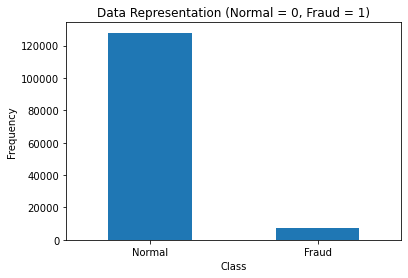

In [94]:
#Check data imbalance w.r.t target value: 'Class'

count_classes = pd.value_counts(train_df['target'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Data Representation (Normal = 0, Fraud = 1)")

LABELS = ["Normal", "Fraud"]
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

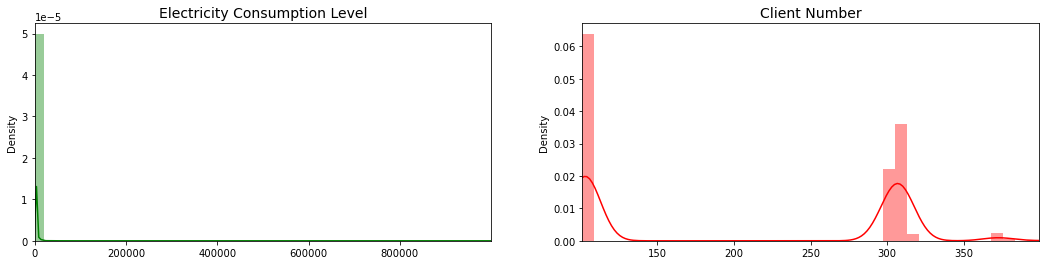

In [95]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = train_df['consommation_level_1_max'].values
time_val = train_df2['region'].values

sns.distplot(amount_val, ax=ax[0], color='g')
ax[0].set_title('Electricity Consumption Level', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='r')
ax[1].set_title('Client Number', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])


plt.show()

In [99]:
tmp = train_df[['consommation_level_1_max','target']].copy()
class_0 = tmp.loc[tmp['target'] == 0]['consommation_level_1_max']
class_1 = tmp.loc[tmp['target'] == 1]['consommation_level_1_max']

In [100]:
class_0.describe()

count    127927.000000
mean       1318.940411
std        3318.667077
min           0.000000
25%         636.000000
50%        1088.000000
75%        1600.000000
max      999910.000000
Name: consommation_level_1_max, dtype: float64

In [102]:
class_1.describe()

count     7566.000000
mean      1759.797119
std       2067.729576
min          0.000000
25%        926.250000
50%       1401.500000
75%       2026.750000
max      62581.000000
Name: consommation_level_1_max, dtype: float64

# Scaling the Data

In [105]:
# #Scaling the Data

# train_df['consumption_level_1_max'] = StandardScaler().fit_transform(train_df['consommation_level_1_max'].values.reshape(-1,1))
# train_df['Region'] = RobustScaler().fit_transform(train_df['region'].values.reshape(-1,1))

# train_df.drop(['consumption_level_1_max', 'Region'], axis = 1, inplace = True)

# amount = train_df['consumption_level_1_max']
# time = train_df['Region']

# train_df.drop(['consumption_level_1_max', 'Region'], axis=1, inplace=True)
# train_df.insert(0, 'consumption_level_1_max', time)
# train_df.insert(1, 'Region', amount)

In [106]:
# df.head(5)

In [107]:
# Since our classes are highly skewed, we should make them equivalent in order to have a normal distribution of the classes.

# Lets shuffle the data before creating the subsamples

df = train_df.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_df = df.loc[df['target'] == 1]
non_fraud_df = df.loc[df['target'] == 0][:7566]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)


In [108]:
new_df.head(5)

,disrict,client_catg,region,target,region_group,coop_time,is_weekday_mean,transactions_count,tarif_type_mean,tarif_type_std,...,months_number_max_mean,counter_type_range,counter_type_max_mean,invoice_month_range,invoice_month_max_mean,invoice_year_range,invoice_year_max_mean,delta_index_range,delta_index_max_mean,consumption_level_1_max
12610,69,11,104,1.0,200,144,0.144928,69,25.710145,14.604695,...,1.916667,NaN,NaN,10,2.212828,12,1.003024,1270,4.710784,0.089457
93363,69,11,104,0.0,200,134,0.218750,64,25.500000,14.614626,...,1.969231,NaN,NaN,10,1.892473,11,1.002872,2827,3.175154,1.367412
80400,62,11,301,0.0,300,29,0.000000,9,11.000000,0.000000,...,1.000000,NaN,NaN,9,2.195122,3,1.000661,1245,2.975305,-0.336528
82752,62,11,371,0.0,300,150,0.000000,38,11.000000,0.000000,...,1.900000,NaN,NaN,8,1.452229,13,1.003230,962,2.810612,-0.054313
127803,69,11,107,1.0,200,84,0.222222,45,25.822222,14.660226,...,2.000000,NaN,NaN,10,1.495468,8,1.001897,2122,3.788835,1.048988


In [109]:
print(new_df['target'].value_counts()/len(new_df)) #Equally Distributed

0.0    0.5
1.0    0.5
Name: target, dtype: float64


In [110]:
new_df.shape

(15132, 110)

In [112]:
# new_df.hist(figsize=(20,20))
# plt.show()

In [113]:
# corr = new_df.corr()

# # plot the heatmap
# fig = plt.figure(figsize=(15,15))
# sns.heatmap(corr, 
#         xticklabels=corr.columns,
#         yticklabels=corr.columns,
#             linewidths=1.0)

In [114]:
X = new_df.iloc[:,0:30].values
y = new_df.iloc[:,30].values

IndexError: single positional indexer is out-of-bounds

In [66]:
#Train-Test-Split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train.shape, y_train.shape, X_test.shape , y_test.shape

((787, 30), (787,), (197, 30), (197,))

In [67]:
print("Number transactions X_train dataset: ", X_train.shape) 
print("Number transactions y_train dataset: ", y_train.shape) 
print("Number transactions X_test dataset: ", X_test.shape) 
print("Number transactions y_test dataset: ", y_test.shape) 

Number transactions X_train dataset:  (787, 30)
Number transactions y_train dataset:  (787,)
Number transactions X_test dataset:  (197, 30)
Number transactions y_test dataset:  (197,)


In [68]:
#SFS

def sfs_features(algo_namem,features_nums):
    sfs_name=SFS(algo_namem, 
                k_features=features_nums, 
                forward=True, 
                floating=False,
                scoring='accuracy',
                cv=5)
    return sfs_name

In [69]:
results_test = {}
results_train = {}
list_algos=[]

In [70]:
def predict(algo_name,X_train,y_train,X_test,y_test,atype='',verbose=0):
    algo_name.fit(X_train, y_train)
    Y_pred = algo_name.predict(X_test)
    acc_train = round(algo_name.score(X_train, y_train) * 100, 2)
    acc_val = round(algo_name.score(X_test, y_test) * 100, 2)
    
    results_test[str(algo_name)[0:str(algo_name).find('(')]+'_'+str(atype)] = acc_val
    results_train[str(algo_name)[0:str(algo_name).find('(')]+'_'+str(atype)] = acc_train
    list_algos.append(str(algo_name)[0:str(algo_name).find('(')])
    if verbose ==0:
        print("Training Accuracy: " + str(acc_train))
        print("Testing  Accuracy: "+ str(acc_val))
    else:
        return Y_pred

In [88]:
def features(sfs_name='sfs1',verbose=0):
    a= (sfs_name.k_feature_idx_[0],sfs_name.k_feature_idx_[1],sfs_name.k_feature_idx_[2])
    if verbose ==0:
        print('Selected features:', sfs_name.k_feature_idx_)
        for i in range (len (sfs_name.k_feature_idx_)):
            print (df.iloc[:,sfs_name.k_feature_idx_[i]].name)
    return a

In [109]:
def roc_graph_cv(algo_name,X,y,cvn=5):
    
    # Run classifier with cross-validation and plot ROC curves
    cv = StratifiedKFold(n_splits=cvn)
    classifier =algo_name

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    i = 0
    for train, test in cv.split(X, y):
        probas_ = classifier.fit(X[train], y[train].ravel()).predict_proba(X[test])
        # Compute ROC curve and area under curve
        fpr, tpr, thresholds = roc_curve(y[test].ravel(), probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.show()

In [90]:
# helping function

def conf(algo_name,X_test, y_test):
    y_pred = algo_name.predict(X_test)
    forest_cm = metrics.confusion_matrix(y_pred, y_test, [1,0])
    sns.heatmap(forest_cm, annot=True, fmt='.2f',xticklabels = ["1", "0"] , yticklabels = ["1", "0"] )
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.title(str(algo_name)[0:str(algo_name).find('(')])

In [101]:
X = new_df.iloc[:,0:30].values
y = new_df.iloc[:,30].values


# T-SNE Implementation

X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X)

# PCA Implementation

X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X)


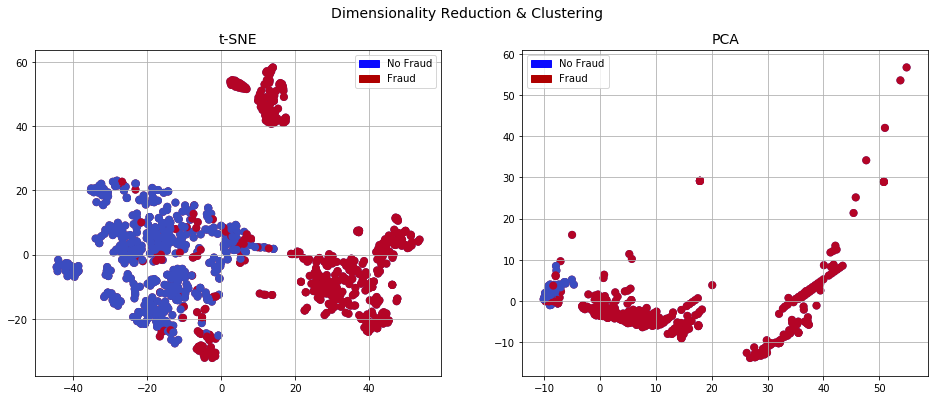

In [103]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
# labels = ['Normal', 'Fraud']
f.suptitle('Dimensionality Reduction & Clustering', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='Normal', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='Normal', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])


In [93]:
#from sklearn.decomposition import PCA
#pca = PCA(n_components=2)
#principalComponents = pca.fit_transform(X)
#principalDf = pd.DataFrame(data = principalComponents
#             , columns = ['principal component 1', 'principal component 2'])
#finalDf = pd.concat([principalDf, df[['Class']]], axis = 1)

#fig = plt.figure(figsize = (8,6))
#ax = fig.add_subplot(1,1,1) 
#ax.set_xlabel('Principal Component 1', fontsize = 15)
#ax.set_ylabel('Principal Component 2', fontsize = 15)
#ax.set_title('2 component PCA', fontsize = 20)
#targets = [0,1]
#colors = ['r',  'b']
#for Class, color in zip(targets,colors):
#    indicesToKeep = finalDf['Class'] == Class
#    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
#               , finalDf.loc[indicesToKeep, 'principal component 2']
#               , c = color
#              , s = 50)
#ax.legend(targets)
#ax.grid()

In [94]:
#LDA

lda = LinearDiscriminantAnalysis()
predict(lda,X_train,y_train,X_test,y_test)

Training Accuracy: 90.6
Testing  Accuracy: 93.4


In [104]:
#LDA with SFS

sfs_1 = sfs_features(lda,(1,5))
sfs_1 = sfs_1.fit(X, y)
selectedFeatures = features(sfs_1)

#plot3D(sfs_1.k_feature_idx_[0],sfs_1.k_feature_idx_[1],sfs_1.k_feature_idx_[2],'knn')

X_train_sfs = sfs_1.transform(X_train)
X_test_sfs = sfs_1.transform(X_test)
print ('\n')
predict(lda,X_train_sfs,y_train,X_test_sfs,y_test,'sfs')

Selected features: (7, 10, 11, 15, 26)
V6
V9
V10
V14
V25


Training Accuracy: 90.22
Testing  Accuracy: 92.89


In [96]:
#lda.explained_variance_ratio_

              precision    recall  f1-score   support

           0       0.89      0.99      0.94       106
           1       0.99      0.86      0.92        91

    accuracy                           0.93       197
   macro avg       0.94      0.92      0.93       197
weighted avg       0.93      0.93      0.93       197



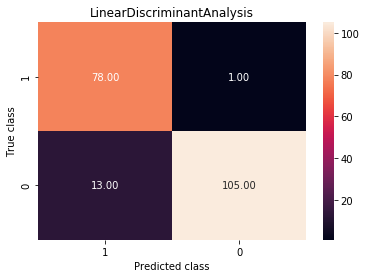

In [105]:
print(classification_report(y_test, lda.predict(X_test_sfs)))
conf(lda,X_test_sfs, y_test)

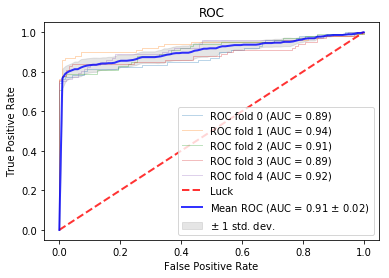

In [110]:
roc_graph_cv(lda,X[:,selectedFeatures],y)

In [115]:
X = new_df.iloc[:,0:30].values
y = new_df.iloc[:,30].values

In [130]:
# Random Forest Classifier

random_forest = RandomForestClassifier(n_estimators=250, random_state = 0)
predict(random_forest,X_train,y_train,X_test,y_test)

Training Accuracy: 100.0
Testing  Accuracy: 97.46


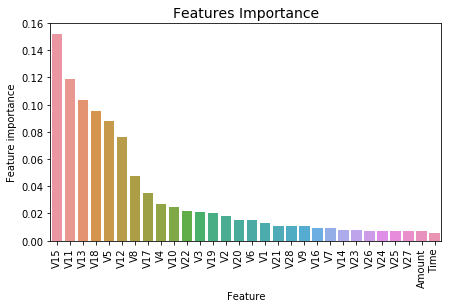

In [117]:
target = 'Class'
predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount']

#Feature Importance

tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': random_forest.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Feature Importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

In [118]:
#Random Forest with SFS

sfs_1 = sfs_features(random_forest,(1,5))
sfs_1 = sfs_1.fit(X, y)
selectedFeatures = features(sfs_1)

#plot3D(sfs_1.k_feature_idx_[0],sfs_1.k_feature_idx_[1],sfs_1.k_feature_idx_[2],'knn')

X_train_sfs = sfs_1.transform(X_train)
X_test_sfs = sfs_1.transform(X_test)
print ('\n')
predict(random_forest,X_train_sfs,y_train,X_test_sfs,y_test,'sfs')

Selected features: (1, 5, 13, 15, 19)
amount
V4
V12
V14
V18


Training Accuracy: 100.0
Testing  Accuracy: 97.97


              precision    recall  f1-score   support

           0       0.97      0.99      0.98       106
           1       0.99      0.97      0.98        91

    accuracy                           0.98       197
   macro avg       0.98      0.98      0.98       197
weighted avg       0.98      0.98      0.98       197



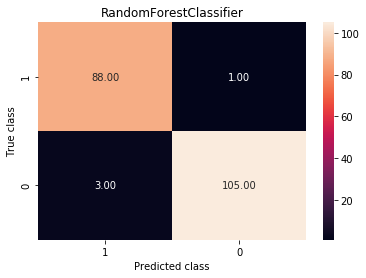

In [119]:
print(classification_report(y_test, random_forest.predict(X_test_sfs)))
conf(random_forest,X_test_sfs, y_test)

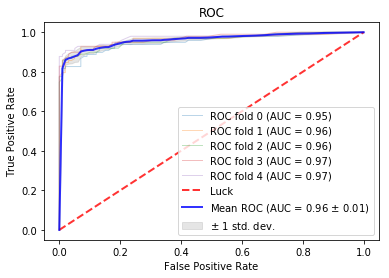

In [120]:
roc_graph_cv(random_forest,X[:,selectedFeatures],y)

In [121]:
#LogisticRegression

lr = LogisticRegression()
predict(lr,X_train,y_train,X_test,y_test)

Training Accuracy: 93.9
Testing  Accuracy: 96.95


## 'LogisticRegression' object has no attribute 'feature_importances_'

In [122]:
#Logistic with SFS

sfs_1 = sfs_features(lr,(1,5))
sfs_1 = sfs_1.fit(X, y)
selectedFeatures = features(sfs_1)

#plot3D(sfs_1.k_feature_idx_[0],sfs_1.k_feature_idx_[1],sfs_1.k_feature_idx_[2],'knn')

X_train_sfs = sfs_1.transform(X_train)
X_test_sfs = sfs_1.transform(X_test)
print ('\n')
predict(lr,X_train_sfs,y_train,X_test_sfs,y_test,'sfs')

Selected features: (2, 5, 12, 13, 15)
V1
V4
V11
V12
V14


Training Accuracy: 92.76
Testing  Accuracy: 97.97


              precision    recall  f1-score   support

           0       0.98      0.98      0.98       106
           1       0.98      0.98      0.98        91

    accuracy                           0.98       197
   macro avg       0.98      0.98      0.98       197
weighted avg       0.98      0.98      0.98       197



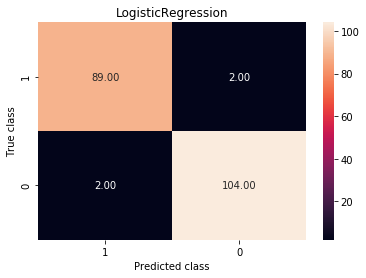

In [126]:
print(classification_report(y_test, lr.predict(X_test_sfs)))
conf(lr,X_test_sfs, y_test)

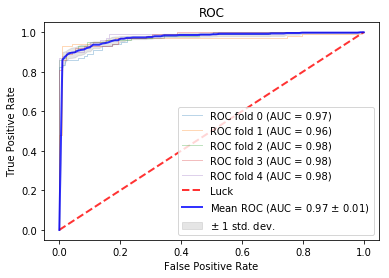

In [135]:
roc_graph_cv(lr,X[:,selectedFeatures],y)

In [129]:
#Extra Trees Classifier

etc = ExtraTreesClassifier(n_estimators=250, random_state=0)
predict(etc,X_train,y_train,X_test,y_test)

Training Accuracy: 100.0
Testing  Accuracy: 97.46


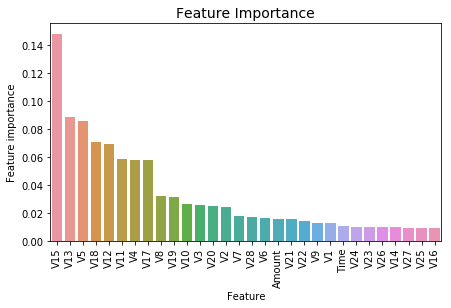

In [131]:
target = 'Class'
predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount']

#Feature Importance

tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': etc.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Feature Importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

In [133]:
#Extra Trees Classifier with SFS

sfs_1 = sfs_features(etc,(1,5))
sfs_1 = sfs_1.fit(X, y)
selectedFeatures = features(sfs_1)

#plot3D(sfs_1.k_feature_idx_[0],sfs_1.k_feature_idx_[1],sfs_1.k_feature_idx_[2],'knn')

X_train_sfs = sfs_1.transform(X_train)
X_test_sfs = sfs_1.transform(X_test)
print ('\n')
predict(etc,X_train_sfs,y_train,X_test_sfs,y_test,'sfs')

Selected features: (2, 5, 15, 17, 29)
V1
V4
V14
V16
V28


Training Accuracy: 100.0
Testing  Accuracy: 98.48


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       106
           1       0.99      0.98      0.98        91

    accuracy                           0.98       197
   macro avg       0.99      0.98      0.98       197
weighted avg       0.98      0.98      0.98       197



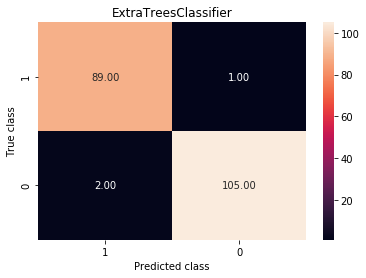

In [134]:
print(classification_report(y_test, etc.predict(X_test_sfs)))
conf(etc,X_test_sfs, y_test)

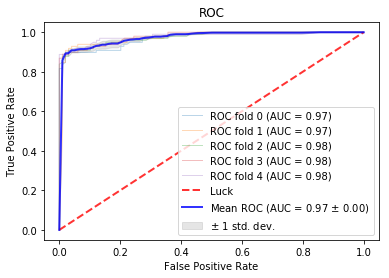

In [136]:
roc_graph_cv(etc,X[:,selectedFeatures],y)

In [137]:
#  Descion Tree

dect = tree.DecisionTreeClassifier()
predict(dect,X_train,y_train,X_test,y_test)

Training Accuracy: 100.0
Testing  Accuracy: 93.91


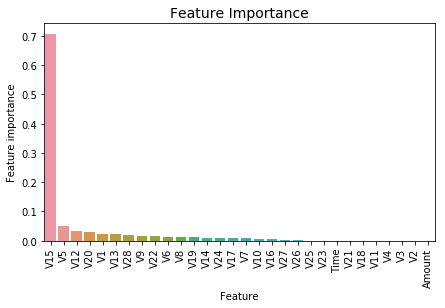

In [138]:
target = 'Class'
predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount']

#Feature Importance

tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': dect.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Feature Importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

In [147]:
#Decision Tree with SFS

sfs_1 = sfs_features(dect,(1,5))
sfs_1 = sfs_1.fit(X, y)
selectedFeatures = features(sfs_1)

#plot3D(sfs_1.k_feature_idx_[0],sfs_1.k_feature_idx_[1],sfs_1.k_feature_idx_[2],'knn')

X_train_sfs = sfs_1.transform(X_train)
X_test_sfs = sfs_1.transform(X_test)
print ('\n')
predict(dect,X_train_sfs,y_train,X_test_sfs,y_test,'sfs')

Selected features: (5, 15, 19, 24)
V4
V14
V18
V23


Training Accuracy: 100.0
Testing  Accuracy: 91.37


              precision    recall  f1-score   support

           0       0.96      0.88      0.92       106
           1       0.87      0.96      0.91        91

    accuracy                           0.91       197
   macro avg       0.91      0.92      0.91       197
weighted avg       0.92      0.91      0.91       197



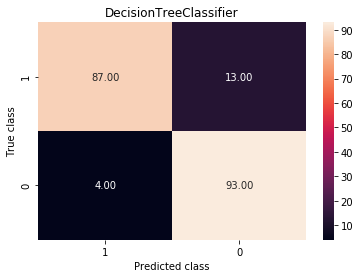

In [148]:
print(classification_report(y_test, dect.predict(X_test_sfs)))
conf(dect,X_test_sfs, y_test)

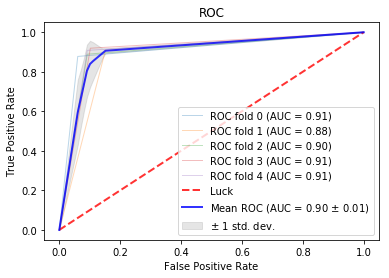

In [149]:
roc_graph_cv(dect,X[:,selectedFeatures],y)

In [166]:
#Support Vector Classifier_Linear

svc = SVC(kernel='linear', probability=True)
predict(svc,X_train,y_train,X_test,y_test, 'linear')

Training Accuracy: 94.16
Testing  Accuracy: 97.46


In [167]:
#Support Vector Classifier_Poly

svc = SVC(kernel='poly', probability=True)
predict(svc,X_train,y_train,X_test,y_test, 'poly')

Training Accuracy: 87.29
Testing  Accuracy: 89.85


In [168]:
#Support Vector Classifier_rbf

svc = SVC(kernel='rbf', probability=True)
predict(svc,X_train,y_train,X_test,y_test, 'rbf')

Training Accuracy: 93.01
Testing  Accuracy: 96.95


## 'SVC' object has no attribute 'feature_importance_'

In [169]:
#Support Vector Classifier with SFS

sfs_1 = sfs_features(svc,(1,5))
sfs_1 = sfs_1.fit(X, y)
selectedFeatures = features(sfs_1)

#plot3D(sfs_1.k_feature_idx_[0],sfs_1.k_feature_idx_[1],sfs_1.k_feature_idx_[2],'knn')

X_train_sfs = sfs_1.transform(X_train)
X_test_sfs = sfs_1.transform(X_test)
print ('\n')
predict(svc,X_train_sfs,y_train,X_test_sfs,y_test,'sfs')

Selected features: (5, 8, 13, 15, 21)
V4
V7
V12
V14
V20


Training Accuracy: 92.88
Testing  Accuracy: 98.48


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       106
           1       0.99      0.98      0.98        91

    accuracy                           0.98       197
   macro avg       0.99      0.98      0.98       197
weighted avg       0.98      0.98      0.98       197



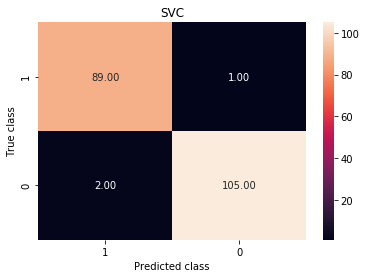

In [170]:
print(classification_report(y_test, svc.predict(X_test_sfs)))
conf(svc,X_test_sfs, y_test)

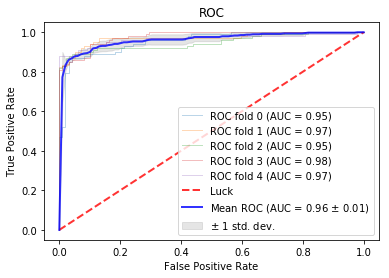

In [172]:
roc_graph_cv(svc,X[:,selectedFeatures],y)

In [150]:
# Gradient Boosting

gbc = GradientBoostingClassifier(loss='exponential', learning_rate=0.03, n_estimators=75 , max_depth=6)
predict(gbc,X_train,y_train,X_test,y_test)

Training Accuracy: 99.75
Testing  Accuracy: 93.91


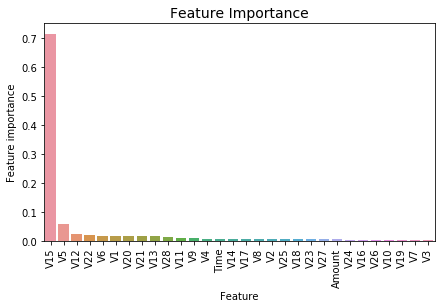

In [152]:
target = 'Class'
predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount']

#Feature Importance

tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': gbc.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Feature Importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

In [151]:
# Gradient Boosting with SFS

sfs_1 = sfs_features(dect,(1,5))
sfs_1 = sfs_1.fit(X, y)
selectedFeatures = features(sfs_1)

#plot3D(sfs_1.k_feature_idx_[0],sfs_1.k_feature_idx_[1],sfs_1.k_feature_idx_[2],'knn')

X_train_sfs = sfs_1.transform(X_train)
X_test_sfs = sfs_1.transform(X_test)
print ('\n')
predict(dect,X_train_sfs,y_train,X_test_sfs,y_test,'sfs')

Selected features: (4, 6, 9, 15, 29)
V3
V5
V8
V14
V28


Training Accuracy: 100.0
Testing  Accuracy: 90.86


              precision    recall  f1-score   support

           0       0.96      0.87      0.91       106
           1       0.86      0.96      0.91        91

    accuracy                           0.91       197
   macro avg       0.91      0.91      0.91       197
weighted avg       0.91      0.91      0.91       197



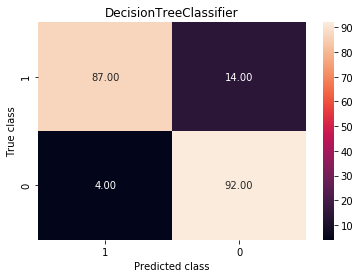

In [153]:
print(classification_report(y_test, dect.predict(X_test_sfs)))
conf(dect,X_test_sfs, y_test)

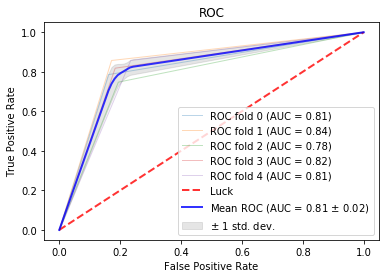

In [154]:
roc_graph_cv(dect,X[:,selectedFeatures],y)

In [180]:
#XGBoost

import xgboost as xgb

xg = xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric="auc")
predict(xg,X_train,y_train,X_test,y_test)

Training Accuracy: 100.0
Testing  Accuracy: 95.94


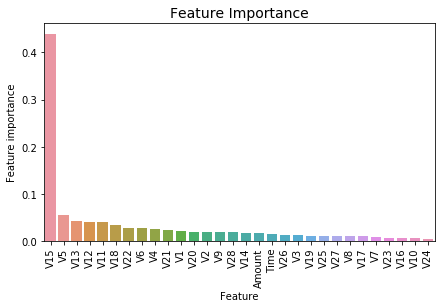

In [181]:
target = 'Class'
predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount']

#Feature Importance

tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': xg.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Feature Importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

In [194]:
#XGBoost with SFS

sfs_1 = sfs_features(xg,(1,5))
sfs_1 = sfs_1.fit(X, y)
selectedFeatures = features(sfs_1)

#plot3D(sfs_1.k_feature_idx_[0],sfs_1.k_feature_idx_[1],sfs_1.k_feature_idx_[2],'knn')

X_train_sfs = sfs_1.transform(X_train)
X_test_sfs = sfs_1.transform(X_test)
print ('\n')
predict(xg,X_train_sfs,y_train,X_test_sfs,y_test,'sfs')

Selected features: (5, 8, 11, 14, 15)
V4
V7
V10
V13
V14


Training Accuracy: 100.0
Testing  Accuracy: 94.42


              precision    recall  f1-score   support

           0       0.97      0.92      0.95       106
           1       0.92      0.97      0.94        91

    accuracy                           0.94       197
   macro avg       0.94      0.95      0.94       197
weighted avg       0.95      0.94      0.94       197



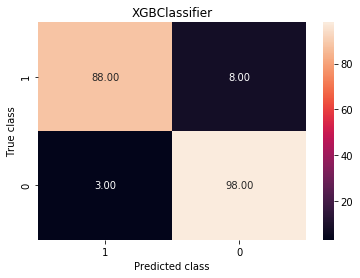

In [195]:
print(classification_report(y_test, xg.predict(X_test_sfs)))
conf(xg,X_test_sfs, y_test)

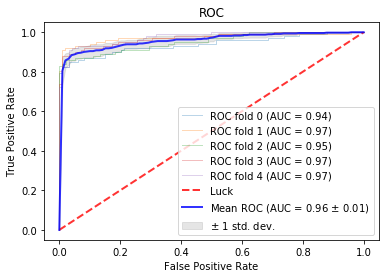

In [196]:
roc_graph_cv(xg,X[:,selectedFeatures],y)

In [188]:
#AdaBoost Classifier

ada = AdaBoostClassifier(n_estimators=100, random_state=0)
predict(ada,X_train,y_train,X_test,y_test)

Training Accuracy: 100.0
Testing  Accuracy: 93.4


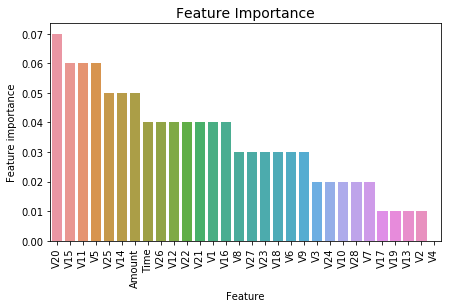

In [189]:
target = 'Class'
predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount']

#Feature Importance

tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': ada.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Feature Importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

In [190]:
#AdaBoost with SFS

sfs_1 = sfs_features(ada,(1,5))
sfs_1 = sfs_1.fit(X, y)
selectedFeatures = features(sfs_1)

#plot3D(sfs_1.k_feature_idx_[0],sfs_1.k_feature_idx_[1],sfs_1.k_feature_idx_[2],'knn')

X_train_sfs = sfs_1.transform(X_train)
X_test_sfs = sfs_1.transform(X_test)
print ('\n')
predict(ada,X_train_sfs,y_train,X_test_sfs,y_test,'sfs')

Selected features: (4, 5, 13, 15)
V3
V4
V12
V14


Training Accuracy: 97.2
Testing  Accuracy: 96.95


              precision    recall  f1-score   support

           0       0.98      0.96      0.97       106
           1       0.96      0.98      0.97        91

    accuracy                           0.97       197
   macro avg       0.97      0.97      0.97       197
weighted avg       0.97      0.97      0.97       197



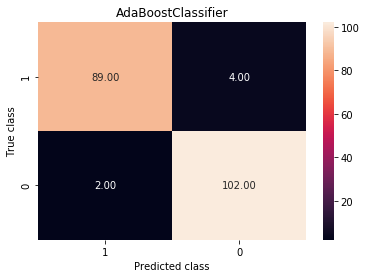

In [191]:
print(classification_report(y_test, ada.predict(X_test_sfs)))
conf(ada,X_test_sfs, y_test)

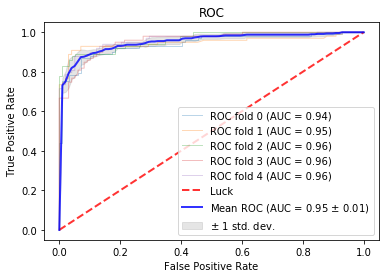

In [192]:
roc_graph_cv(ada,X[:,selectedFeatures],y)

The optimal number of neighbors is 2 with 92.5%


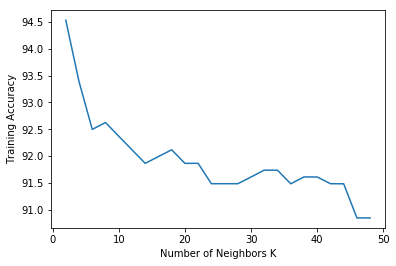

In [204]:
from sklearn import model_selection

#Neighbors
neighbors = [x for x in list(range(1,50)) if x % 2 == 0]

#Create empty list that will hold cv scores
cv_scores = []

#Perform 10-fold cross validation on training set for odd values of k:
seed=123
for k in neighbors:
    k_value = k+1
    knn = KNeighborsClassifier(n_neighbors = k_value, weights='uniform', p=2, metric='euclidean')
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    scores = model_selection.cross_val_score(knn, X_train, y_train, cv=kfold, scoring='accuracy')
    cv_scores.append(scores.mean()*100)
    #print("k=%d %0.2f (+/- %0.2f)" % (k_value, scores.mean()*100, scores.std()*100))

    optimal_k = neighbors[cv_scores.index(max(cv_scores))]
print(( "The optimal number of neighbors is %d with %0.1f%%" % (optimal_k, cv_scores[optimal_k])))

plt.plot(neighbors, cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Training Accuracy')
plt.show()

In [200]:
# K Neighbours Classifier

knn = KNeighborsClassifier()
predict(knn,X_train,y_train,X_test,y_test)

Training Accuracy: 95.93
Testing  Accuracy: 95.94


## 'KNeighborsClassifier' object has no attribute 'feature_importances_'

In [201]:
# K Neighbours Classifier with SFS

sfs_1 = sfs_features(knn,(1,5))
sfs_1 = sfs_1.fit(X, y)
selectedFeatures = features(sfs_1)

#plot3D(sfs_1.k_feature_idx_[0],sfs_1.k_feature_idx_[1],sfs_1.k_feature_idx_[2],'knn')

X_train_sfs = sfs_1.transform(X_train)
X_test_sfs = sfs_1.transform(X_test)
print ('\n')
predict(knn,X_train_sfs,y_train,X_test_sfs,y_test,'sfs')

Selected features: (2, 5, 15, 28)
V1
V4
V14
V27


Training Accuracy: 94.92
Testing  Accuracy: 95.43


              precision    recall  f1-score   support

           0       0.94      0.98      0.96       106
           1       0.98      0.92      0.95        91

    accuracy                           0.95       197
   macro avg       0.96      0.95      0.95       197
weighted avg       0.96      0.95      0.95       197



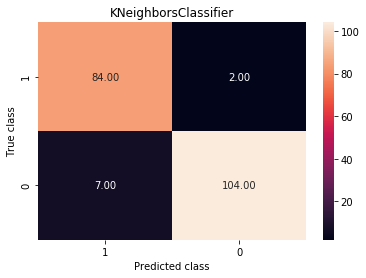

In [202]:
print(classification_report(y_test, knn.predict(X_test_sfs)))
conf(knn,X_test_sfs, y_test)

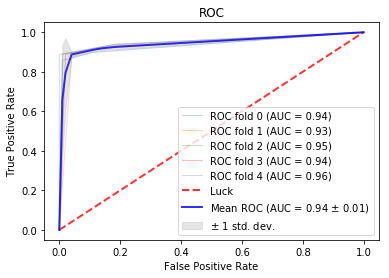

In [203]:
roc_graph_cv(knn,X[:,selectedFeatures],y)

In [207]:
# Gaussian Naive_bayes

g = GaussianNB()
predict(g,X_train,y_train,X_test,y_test)

Training Accuracy: 90.47
Testing  Accuracy: 95.43


## 'GaussianNB' object has no attribute 'feature_importances_'

In [214]:
# Gaussian Naive_bayes with SFS

sfs_1 = sfs_features(g,(1,5))
sfs_1 = sfs_1.fit(X, y)
selectedFeatures = features(sfs_1)

#plot3D(sfs_1.k_feature_idx_[0],sfs_1.k_feature_idx_[1],sfs_1.k_feature_idx_[2],'knn')

X_train_sfs = sfs_1.transform(X_train)
X_test_sfs = sfs_1.transform(X_test)
print ('\n')
predict(g,X_train_sfs,y_train,X_test_sfs,y_test,'sfs')

Selected features: (0, 5, 15, 18)
time
V4
V14
V17


Training Accuracy: 91.99
Testing  Accuracy: 97.97


              precision    recall  f1-score   support

           0       0.98      0.98      0.98       106
           1       0.98      0.98      0.98        91

    accuracy                           0.98       197
   macro avg       0.98      0.98      0.98       197
weighted avg       0.98      0.98      0.98       197



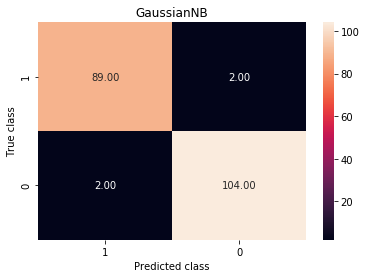

In [215]:
print(classification_report(y_test, g.predict(X_test_sfs)))
conf(g,X_test_sfs, y_test)

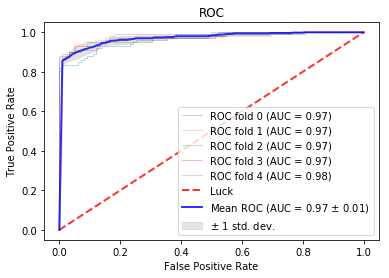

In [216]:
roc_graph_cv(g,X[:,selectedFeatures],y)

In [217]:
# print (results_test)

df_test =pd.DataFrame(list(results_test.items()),
                      columns=['Algorithm,'Test_Acc'])
df_train =pd.DataFrame(list(results_train.items()),
                      columns=['Algorithm','Train_Acc'])
df_results = df_test.join(df_train.set_index('Algorithm'), on='Algorithm')
df_results.sort_values('Test_Acc',ascending=False)

,Algorithm,Test_Acc,Train_Acc
12,SVC_sfs,98.48,92.88
7,ExtraTreesClassifier_sfs,98.48,100.00
5,LogisticRegression_sfs,97.97,92.76
24,GaussianNB_sfs,97.97,91.99
3,RandomForestClassifier_sfs,97.97,100.00
6,ExtraTreesClassifier_,97.46,100.00
2,RandomForestClassifier_,97.46,100.00
13,SVC_linear,97.46,94.16
4,LogisticRegression_,96.95,93.90
20,AdaBoostClassifier_sfs,96.95,97.20
